In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint as sp_randint
from sklearn import preprocessing
from xgboost import XGBRegressor

import extract_location_features
import preprocessing

In [2]:
# extract_location_features.main()
# preprocessing.main()

In [3]:
df = pd.read_csv('data/train_preprocessed.csv', sep='\t')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431732 entries, 0 to 431731
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 431732 non-null  int64  
 1   month                431732 non-null  int64  
 2   num_rooms            431732 non-null  int64  
 3   is_executive         431732 non-null  bool   
 4   is_multi_gen         431732 non-null  bool   
 5   storey_range_avg     431732 non-null  float64
 6   is_low_floor         431732 non-null  int64  
 7   floor_area_sqm       431732 non-null  float64
 8   lease_commence_date  431732 non-null  int64  
 9   latitude             431732 non-null  float64
 10  longitude            431732 non-null  float64
 11  elevation            431732 non-null  float64
 12  town                 431732 non-null  object 
 13  block                431732 non-null  object 
 14  street_name          431732 non-null  object 
 15  flat_model       

In [5]:
df.head()

,year,month,num_rooms,is_executive,is_multi_gen,storey_range_avg,is_low_floor,floor_area_sqm,lease_commence_date,latitude,...,block,street_name,flat_model,subzone,planning_area,region,cbd_dist,nearest_center,n_center_dist,resale_price
0,2001,8,4,False,False,2.0,1,118.0,1989,1.369008,...,440,pasir ris drive 4,model a,pasir ris drive,pasir ris,east region,14.755260,3,2.314,209700.0
1,2014,10,5,False,False,11.0,0,110.0,2003,1.399007,...,196B,punggol field,improved,punggol field,punggol,north-east region,13.775751,16,1.462,402300.0
2,2020,9,5,False,False,2.0,1,112.0,2004,1.388348,...,404A,fernvale lane,premium apartment,fernvale,sengkang,north-east region,11.496847,18,1.445,351000.0
3,2000,10,3,False,False,8.0,0,67.0,1980,1.318493,...,375,clementi avenue 4,new generation,clementi north,clementi,west region,10.381140,9,2.387,151200.0
4,2013,1,3,False,False,8.0,0,73.0,1985,1.348149,...,163,bukit batok street 11,model a,bukit batok west,bukit batok,west region,14.185992,1,1.807,318600.0


In [6]:
# convert string to categorical variables
df['town'] = df['town'].astype('category')
df['block'] = df['block'].astype('category')
df['street_name'] = df['street_name'].astype('category')
df['flat_model'] = df['flat_model'].astype('category')
df['subzone'] = df['subzone'].astype('category')
df['planning_area'] = df['planning_area'].astype('category') # 32 planning_areas
df['region'] = df['region'].astype('category') # 5 regions
df['nearest_center'] = df['nearest_center'].astype('category')

In [7]:
x_num_cols = ['year', 'month', 'num_rooms', 'is_executive', 'is_multi_gen', 'storey_range_avg', 'is_low_floor', 'floor_area_sqm', 'lease_commence_date', 'latitude', 'cbd_dist', 'longitude', 'n_center_dist']
x_cat_cols = ['flat_model', 'planning_area', 'nearest_center']
y_col = 'resale_price'

In [8]:
encoder = OneHotEncoder(drop='first').fit(df[x_cat_cols])
X_cat_encoded = pd.DataFrame(encoder.transform(df[x_cat_cols]).toarray(), columns=encoder.get_feature_names_out())

In [9]:
X_encoded = pd.concat([df[x_num_cols], X_cat_encoded], axis=1)

In [10]:
scaler = StandardScaler().fit(X_encoded)
X_scaled = pd.DataFrame(scaler.transform(X_encoded), columns=X_encoded.columns)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df[y_col], test_size=0.33)

In [12]:
results = {}

# Linear Regression

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
res = [mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)]
results['linear_regression'] = res
print("MSE: {:.2f}, r2: {:.2f}".format(*res))

MSE: 3058176631.00, r2: 0.82


# Random Forest

In [14]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=10)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
res = [mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)]
results['random_forest'] = res
print("MSE: {:.2f}, r2: {:.2f}".format(*res))

MSE: 1007989947.64, r2: 0.94


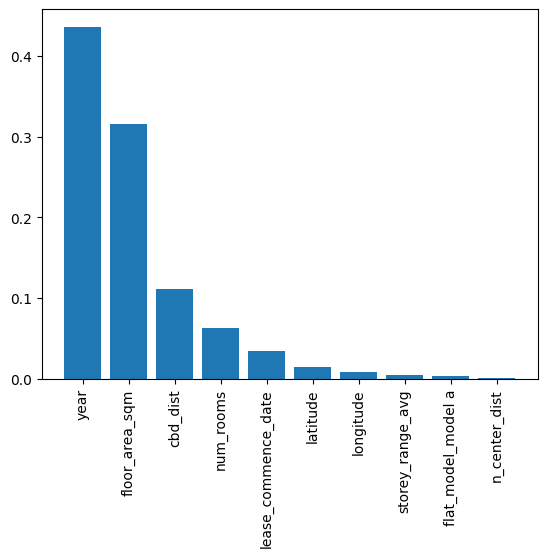

In [26]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_
# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))
# Create tick labels 
labels = np.array(X_train.columns)[sorted_index]
plt.bar(range(10), importances[sorted_index][:10], tick_label=labels[:10])
# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

# Gradient Boosting

In [15]:
# TODO: no parameter tuning yet
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)
y_pred = gbr_model.predict(X_test)
res = [mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)]
results['gradient_boosting'] = res
print("MSE: {:.2f}, r2: {:.2f}".format(*res))

MSE: 1085618024.46, r2: 0.94


# AdaBoost

In [16]:
ada_model = AdaBoostRegressor()
ada_model.fit(X_train, y_train)
y_pred = ada_model.predict(X_test)
res = [mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)]
results['ada_boost'] = res
print("MSE: {:.2f}, r2: {:.2f}".format(*res))

MSE: 5658664747.80, r2: 0.66


# XGBoost

In [17]:
# I was told this is a regressor popular in industry...
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
res = [mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)]
results['xgboost'] = res
print("MSE: {:.2f}, r2: {:.2f}".format(*res))

MSE: 411451920.41, r2: 0.98


In [18]:
np.round(pd.DataFrame.from_dict(results, orient='index', columns=['MSE', 'r2']), 2)

,MSE,r2
linear_regression,3.058177e+09,0.82
random_forest,1.007990e+09,0.94
gradient_boosting,1.085618e+09,0.94
ada_boost,5.658665e+09,0.66
xgboost,4.114519e+08,0.98


# Prediction

In [19]:
test = pd.read_csv('data/test_preprocessed.csv', sep='\t')

In [20]:
test.head()

,year,month,num_rooms,is_executive,is_multi_gen,storey_range_avg,is_low_floor,floor_area_sqm,lease_commence_date,latitude,...,town,block,street_name,flat_model,subzone,planning_area,region,cbd_dist,nearest_center,n_center_dist
0,2004,1,4,False,False,5.0,1,94.0,1989,1.346581,...,bukit batok,186,bukit batok west avenue 6,new generation,bukit batok west,bukit batok,west region,13.963190,1,1.750
1,2001,11,5,False,False,5.0,1,122.0,1997,1.357618,...,tampines,366,tampines street 34,improved,tampines east,tampines,east region,14.253167,3,1.866
2,2002,7,3,False,False,2.0,1,67.0,1982,1.337804,...,jurong east,206,jurong east street 21,new generation,toh guan,jurong east,west region,13.736600,1,0.929
3,2015,4,3,False,False,5.0,1,82.0,1981,1.380084,...,ang mo kio,180,Ang Mo Kio Avenue 5,new generation,yio chu kang east,ang mo kio,north-east region,10.390801,18,2.027
4,2004,4,5,False,False,2.0,1,117.0,1978,1.313960,...,clementi,356,clementi avenue 2,standard,clementi north,clementi,west region,9.889045,28,2.400


In [21]:
test['town'] = test['town'].astype('category')
test['block'] = test['block'].astype('category')
test['street_name'] = test['street_name'].astype('category')
test['flat_model'] = test['flat_model'].astype('category')
test['subzone'] = test['subzone'].astype('category')
test['planning_area'] = test['planning_area'].astype('category')
test['region'] = test['region'].astype('category')
test['nearest_center'] = test['nearest_center'].astype('category')

In [22]:
X_cat_encoded_final = pd.DataFrame(encoder.transform(test[x_cat_cols]).toarray(), columns=encoder.get_feature_names_out())
X_encoded_final = pd.concat([test[x_num_cols], X_cat_encoded_final], axis=1)
X_scaled_final = pd.DataFrame(scaler.transform(X_encoded_final), columns=X_encoded_final.columns)

In [23]:
y_final = xgb_model.predict(X_scaled_final)

In [24]:
y_final

array([191216.9 , 313269.12, 119683.41, ..., 162296.5 , 248114.94,
       327756.16], dtype=float32)

In [25]:
pd.DataFrame({'Id':test.index, 'Predicted':y_final}).to_csv('prediction.csv', index=False)